In [5]:
import sys
import os

import pandas as pd
import numpy as np
import natsort
import random as rn
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
import pyeeg

from scipy import signal
from scipy.signal import (welch, medfilt, wiener,savgol_filter)
from scipy.integrate import simps

import matplotlib.pyplot as plt

#Keras

#Sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPRegressor
from sklearn.svm import (SVC, SVR)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import (StratifiedKFold, KFold)
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.metrics import (accuracy_score, make_scorer, balanced_accuracy_score, roc_auc_score, mean_squared_error)

from sklearn.model_selection import GridSearchCV

from sklearn.manifold import TSNE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

seed=42
np.random.seed(seed)
rn.seed(seed)
tf.set_random_seed(seed)
dir_path = os.getcwd()
# https://en.wikipedia.org/wiki/Neural_oscillation
SAMPLE_PER_SEC = 128
DELTA_WAVE = [1, 4]
THETA_WAVE = [4, 8]
ALPHA_WAVE = [7.5, 12.5]
BETA_WAVE = [13, 30]
TOTAL_ENERGY = [0, 64]
# not used
LOW_GAMMA_WAVE = [30, 70]
HIGH_GAMMA_WAVE = [70, 150]

EPSILON =  0.0002
FILTER_WINDOW = 5

In [8]:
def get_train_from_csv(csv_file):
    '''
    get a numpy array y of labels. the order follows the id of 4 second sample. 
    argument: relative path to the csv_file from the source folder.
    '''
    csv_file = os.path.join(dir_path, csv_file)
    print(f"Reading {csv_file}")
    with open(csv_file, 'r') as csvfile:
        train_reader = pd.read_csv(csvfile)
        train_reader.drop(labels="Id", axis=1, inplace=True)
        
        
    return train_reader.values

def get_target_from_csv(csv_file):
    '''
    get a numpy array y of labels. the order follows the id of 4 second sample. 
    argument: relative path to the csv_file from the source folder.
    '''
    csv_file = os.path.join(dir_path,csv_file)
    with open(csv_file, 'r') as csvfile:
        label_reader = pd.read_csv(csvfile)
        #print("Labels: ", label_reader['id'])
        y = label_reader['y']
        
    y = np.array(y)
    return y

def get_features_emg(X):
    all_featues = []
    for i in tqdm(range(X.shape[0])):
        features = list()
        # https://ieeexplore.ieee.org/document/7748960
        x_i = X[i,:]
        # Root Mean Square (RMS): RMS of EMG
        features.append(mean_squared_error(x_i, np.zeros(x_i.shape)))
        
        #Integrated Absolute Value (IAV)
        features.append(np.sum(np.abs(x_i)))
        
        # Mean Absolute Value (MAV): MAV feature can be expressed as
        features.append(np.mean(x_i))
        
        # TBD:
        # Modified Mean Absolute Value type 1
        # Modified Mean Absolute Value type 2
        
        # Simple Square Integral (SSI): SSI is calculated as
        features.append(np.sum(x_i ** 2))
        
        # Variance (VAR): VAR is calculated as
        features.append(np.var(x_i))
        
        #The 3rd, 4th and 5th temporal moments
        features.append(np.mean(x_i ** 3))
        features.append(np.mean(x_i ** 4))
        features.append(np.mean(x_i ** 5))
        
        # TBD
        # v-Order 
        
        # Waveform Length
        features.append(np.sum(np.abs(np.diff(x_i))))
        
        # Average Amplitude Change
        features.append(np.mean(np.abs(np.diff(x_i))))
        
        # Difference Absolute Standard Deviation Value
        features.append(np.sqrt(np.mean(np.power(np.diff(x_i), 2))))
        
        # AX BASIC FEATUERS
        features.append(np.std(x_i))
        features.append(np.min(x_i))
        features.append(np.max(x_i))
        features.append(np.sum(np.abs(x_i) > EPSILON))
        
        
        
        all_featues.append(features)
    return np.array(all_featues)

def get_features_eeg(X):
    all_featues = []
    # NOT SURE ABOUT THIS VALUES 
    # LETS DOUBLE CHECK
    K_MAX = 6
    SAMPLE_PER_SEC = 32
    FREQ_BANDS = list(range(16))
    TAU = 16
    # embedding dimension
    DE = 32
    
    for i in tqdm(range(X.shape[0])):
        features = list()
        # http://pyeeg.sourceforge.net/
        x_i = X[i,:]
        
        # Power Spectral Intensity (PSI) and Relative Intensity Ratio (RIR)	bin_power()	Two 1-D vectors
        
        
        # Petrosian Fractal Dimension (PFD)	pdf()	A scalar
        features.append(pyeeg.pfd(x_i))
        
        # Higuchi Fractal Dimension (HFD)	hfd()	A scalar
        features.append(pyeeg.hfd(x_i, K_MAX))
        
        # Hjorth mobility and complexity	hjorth()	Two scalars
        
        # Spectral Entropy (Shannon's entropy of RIRs)	spectral_entropy()	A scalar
        #features.append(pyeeg.spectral_entropy(x_i, FREQ_BANDS, SAMPLE_PER_SEC))
        
        # SVD Entropy	svd_entropy()	A scalar
        #features.append(pyeeg.svd_entropy(x_i, TAU, DE))
        
        # Fisher Information	fisher_info()	A scalar
        features.append(pyeeg.fisher_info(x_i, TAU, DE))
          
        # Detrended Fluctuation Analysis (DFA)	dfa()	A scalar
        features.append(pyeeg.dfa(x_i))
        
        # Hurst Exponent (Hurst)	hurst()	A scalar
        #features.append(pyeeg.hurst(x_i))
        
        # AX BASIC FEATUERS
        features.append(np.mean(x_i))
        features.append(np.std(x_i))
        features.append(np.min(x_i))
        features.append(np.max(x_i))
        features.append(np.sum(np.abs(x_i) > EPSILON))
        
        """
            DELTA_WAVE = [1, 4]
            THETA_WAVE = [4, 8]
            ALPHA_WAVE = [7.5, 12.5]
            BETA_WAVE = [13, 30]
        """
        delta = bandpower(x_i, DELTA_WAVE)
        theta = bandpower(x_i, THETA_WAVE)
        alpha = bandpower(x_i, ALPHA_WAVE)
        beta = bandpower(x_i, BETA_WAVE)
        total_energy = bandpower(x_i, TOTAL_ENERGY)
        
        
        features.append(delta)
        features.append(theta)
        features.append(alpha)
        features.append(beta)
        
        
        features.append(delta / total_energy)
        features.append(theta / total_energy)
        features.append(alpha / total_energy)
        features.append(beta / total_energy)
        
        
        
        all_featues.append(features)
    return np.array(all_featues)


def get_data_of_rat(X, y, i):
    sample_cnt = int(X.shape[0] / 3)
    if i == 0:
        return X[:sample_cnt, :], y[:sample_cnt]
    if i == 1:
        return X[sample_cnt: 2 * sample_cnt, :], y[sample_cnt: 2 * sample_cnt]
    if i == 2:
        return X[2 * sample_cnt:, :], y[2 * sample_cnt:]
    
    
def bandpower(data, band, window_sec=4, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.

    Examples
    ------
    1. Absolute and relative power in the delta band
        >>> delta = bandpower(data, 100, [0.5, 4])
        >>> delta_relative = bandpower(data, 100, [0.5, 4], relative=True)

    2. Delta / beta ratio
        >>> window_sec = 4
        >>> delta = bandpower(data, 100, [0.5, 4], window_sec)
        >>> beta = bandpower(data, 100, [12, 30], window_sec)
        >>> db_ratio = delta / beta
    """
    
    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if window_sec is not None:
        nperseg = window_sec * SAMPLE_PER_SEC
    else:
        nperseg = (2 / low) * SAMPLE_PER_SEC

    freqs, psd = welch(data, SAMPLE_PER_SEC, nperseg=nperseg, scaling='density')

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs < high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], freqs[idx_band])

    if relative:
        bp /= simps(psd, freqs)
    return bp

def remove_impossible_transitions(y_pred):
    last = y_pred[0]
    cnt = 0
    for i in range(1, y_pred.shape[0]):
        cur = y_pred[i]
        if last == 1 and cur == 3:
            y_pred[i - 1] = 2
            #break
        last = cur
    return y_pred

In [7]:
# Load the data
# train
train_emg = os.path.join(dir_path,"data/train/train_emg.csv")
train_eeg_1 = os.path.join(dir_path,"data/train/train_eeg1.csv")
train_eeg_2 = os.path.join(dir_path,"data/train/train_eeg2.csv")

# trest
test_emg = os.path.join(dir_path,"data/test/test_emg.csv")
test_eeg_1 = os.path.join(dir_path,"data/test/test_eeg1.csv")
test_eeg_2 = os.path.join(dir_path,"data/test/test_eeg2.csv")

# labels
train_target = os.path.join(dir_path,'data/train/train_labels.csv')

x_train_emg = get_train_from_csv(train_emg) #List of numpy arrays
x_train_eeg_1 = get_train_from_csv(train_eeg_1) #List of numpy arrays
x_train_eeg_2 = get_train_from_csv(train_eeg_2) #List of numpy arrays
y_train = get_target_from_csv(train_target) #Numpy array of labels

x_test_emg = get_train_from_csv(test_emg) #List of numpy arrays
x_test_eeg_1 = get_train_from_csv(test_eeg_1) #List of numpy arrays
x_test_eeg_2 = get_train_from_csv(test_eeg_2) #List of numpy arrays

print(f"Class 1: {np.sum(y_train == 1)}")
print(f"Class 2: {np.sum(y_train == 2)}")
print(f"Class 3: {np.sum(y_train == 3)}")

Reading /home/ax/master/2018_02/ml/task5/data/train/train_emg.csv
Reading /home/ax/master/2018_02/ml/task5/data/train/train_eeg1.csv
Reading /home/ax/master/2018_02/ml/task5/data/train/train_eeg2.csv
Reading /home/ax/master/2018_02/ml/task5/data/test/test_emg.csv
Reading /home/ax/master/2018_02/ml/task5/data/test/test_eeg1.csv
Reading /home/ax/master/2018_02/ml/task5/data/test/test_eeg2.csv
Class 1: 34114
Class 2: 27133
Class 3: 3553


In [61]:
last = y_train[0]
cnt = 0
for i in range(1, y_train.shape[0]):
    cur = y_train[i]
    if last == 1 and cur == 3:
        cnt += 1
        #break
    last = cur
print(f"#{cnt}: transitions from 1 to 3 found")

#1: transitions from 1 to 3 found


In [10]:
# compute features

print("Computing features for training set ..")
x_train_emg_feat = get_features_emg(x_train_emg)
x_train_eeg_1_feat = get_features_eeg(x_train_eeg_1)
x_train_eeg_2_feat = get_features_eeg(x_train_eeg_2)

print("Computing features for test set ..")
x_test_emg_feat = get_features_emg(x_test_emg)
x_test_eeg_1_feat = get_features_eeg(x_test_eeg_1)
x_test_eeg_2_feat = get_features_eeg(x_test_eeg_2)

Computing features for training set ..



Computing features for test set ..


In [19]:
print("\nTRAIN")
print(x_train_eeg_1_feat.shape)
print(x_train_eeg_2_feat.shape)
print(x_train_emg_feat.shape)
print("\nTEST")
print(x_test_eeg_1_feat.shape)
print(x_test_eeg_2_feat.shape)
print(x_test_emg_feat.shape)

X_train = np.concatenate((x_train_emg_feat,x_train_eeg_1_feat,x_train_eeg_2_feat), axis = 1)
print("X train final shape -> ",X_train.shape)
X_test = np.concatenate((x_test_emg_feat,x_test_eeg_1_feat,x_test_eeg_2_feat), axis = 1)
print("X test final shape -> ",X_test.shape)

pd.DataFrame(data=X_train).to_csv("features/all_combined_train.csv", index=False)
pd.DataFrame(data=y_train).to_csv("features/all_combined_label.csv", index=False)
pd.DataFrame(data=X_test).to_csv("features/all_combined_test.csv", index=False)



TRAIN
(64800, 17)
(64800, 17)
(64800, 15)

TEST
(43200, 17)
(43200, 17)
(43200, 15)
X train final shape ->  (64800, 49)
X test final shape ->  (43200, 49)


In [8]:
# LOAD THE FEATURES FROM CSV
X_train = pd.read_csv("features/all_combined_train.csv").values
y_train = np.ravel(pd.read_csv("features/all_combined_label.csv").values)
X_test = pd.read_csv("features/all_combined_test.csv").values

print("X train final shape -> ",X_train.shape)
print("X test final shape -> ",X_test.shape)


X train final shape ->  (64800, 49)
X test final shape ->  (43200, 49)


In [9]:
#Fit scaler on all data
X_total = np.concatenate((X_train, X_test))
print("X total shape -> ", X_total.shape)

scaler = StandardScaler().fit(X_total)

X total shape ->  (108000, 49)


In [16]:
# class weights
classes = np.array([1,2,3])
weights = compute_class_weight("balanced", classes, y_train)
cw = dict(zip(classes, weights))

# classifiers for CV
rf = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1, verbose=False, class_weight = cw)
svc = SVC(class_weight="balanced", 
          random_state=seed, 
          C=0.01,
          verbose=True,
          gamma=0.0003)
kernel = 1.0 * RBF(1.0)
gbc = GradientBoostingClassifier(random_state=seed)
abc = AdaBoostClassifier(random_state=seed)
classifiers = [abc, gbc,  svc]
classifiers_names = [ "GradientBoostingClassifier", "AdaBoostClassifier", "SVC"]

In [ ]:
# CROSS VALDATION
kfold = KFold(n_splits=3, shuffle=False, random_state=seed)

print("Start")

clf_scores_avg = []
clf_scores_std = []
for clf in classifiers:
    bmac_scores = []
    for train, valid in kfold.split(X_train):
        # get the folds
        X_train_fold = X_train[train]
        y_train_fold = y_train[train]

        X_valid_fold = X_train[valid]
        y_valid_fold = y_train[valid]

        X_train_fold_scaled = scaler.transform(X_train_fold)
        X_valid_fold_scaled = scaler.transform(X_valid_fold)

        # fit classifier
        clf.fit(X_train_fold_scaled, y_train_fold)

        y_pred = clf.predict(X_valid_fold_scaled)
        
        #remove impossible 
        #y_pred = remove_impossible_transitions(y_pred)
        
        # median filter
        y_pred = medfilt(y_pred, FILTER_WINDOW)
        

        bmac_score_rf = balanced_accuracy_score(y_valid_fold, y_pred)
        print(f"{len(bmac_scores)}: current balanced_accuracy_score: {bmac_score_rf}")

        bmac_scores.append(bmac_score_rf)
    
    clf_scores_avg.append(np.mean(bmac_scores))
    clf_scores_std.append(np.std(bmac_scores))

print("================================================================================")
for i in range(len(classifiers)):
    print(f"{classifiers_names[i]} BMAC avg score {clf_scores_avg[i]} +/- {clf_scores_std[i]}" )

print("================================================================================")
print("================================================================================")

print("DEFAULT 0.924203064567119 +/- 0.026768125976249342")
print("GAMMA = 0.0004 0.9401296487697763 +/- 0.02925282597198205")
print("GAMMA = 0.0004 C=0.1 0.9434637293201353 +/- 0.0257096513820207")
print("GAMMA = 0.0004 C=0.01 0.930809065681996 +/- 0.022307773367821106")

Start
0: current balanced_accuracy_score: 0.869770834617804
1: current balanced_accuracy_score: 0.8739893110032421
2: current balanced_accuracy_score: 0.5074708704983458
0: current balanced_accuracy_score: 0.8516414660580303
1: current balanced_accuracy_score: 0.9425043703454304
2: current balanced_accuracy_score: 0.4536450193291793
[LibSVM]

In [9]:
#Scale, fit, predict
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#an estimator (regressor or classifier such as sklearn.svm.SVC());
svc = SVC(class_weight="balanced", random_state=seed, C=0.1, gamma=0.0003)
#a parameter space;
param_grid = [{'C': [0.1, 0.05], 
               'gamma': [0.0003, 0.00025], 
               'kernel': ['rbf']}]
#a method for searching or sampling candidates;

#a cross-validation scheme; and
kfold = KFold(n_splits=3, shuffle=False, random_state=seed)
#a score function.

clf = GridSearchCV(estimator=svc, param_grid=param_grid, n_jobs=-1, scoring=make_scorer(balanced_accuracy_score), cv=kfold, verbose=10)
print("start grid search ...")
clf.fit(X_train_scaled, y_train)
# View the accuracy score
print('Best score:', clf.best_score_)
# View the best parameters for the model found using grid search
print('Best C:',clf.best_estimator_.C) 
print('Best Kernel:',clf.best_estimator_.kernel)
print('Best Gamma:',clf.best_estimator_.gamma)


start grid search ...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:  6.6min remaining: 19.7min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:  6.9min remaining:  9.6min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  7.9min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed: 11.5min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 12.4min finished


In [10]:


svc = SVC(class_weight="balanced", random_state=seed, gamma=0.0004, C=0.1)
svc.fit(X_train_scaled, y_train)

# apply median filter



SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0004, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [11]:
y_pred_filtered = svc.predict(X_test_scaled)
# CORRECT all  predictions 1 to 3
#y_pred_filtered = remove_impossible_transitions(y_pred_filtered)

#  medfilt, wiener,savgol_filter
y_pred_filtered = medfilt(y_pred_filtered, FILTER_WINDOW)

Class 1: 18745
Class 2: 22408
Class 3: 2047


'\nClass 1: 23933\nClass 2: 18553\nClass 3: 714\n'

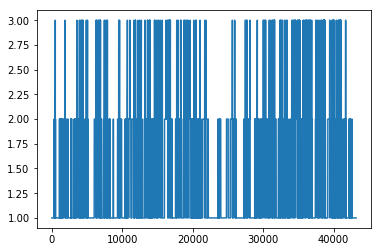

In [12]:
submission_name = "ax_allfeat_with_bandwidth_filter_gamma_C.csv"

print(f"Class 1: {np.sum(y_pred_filtered == 1)}")
print(f"Class 2: {np.sum(y_pred_filtered == 2)}")
print(f"Class 3: {np.sum(y_pred_filtered == 3)}")

y_pred_df = pd.DataFrame(y_pred_filtered)
y_pred_df = y_pred_df.assign(Id=list(range(y_pred_filtered.shape[0])))
y_pred_df.columns = ['y', 'Id']
y_pred_df["y"].plot()
submission_folder = os.path.join(dir_path,"submissions/")
csv_file = submission_folder + submission_name

with open(csv_file, 'w') as csv:
    y_pred_df.to_csv(csv,index = False)
"""
Class 1: 23933
Class 2: 18553
Class 3: 714
"""